In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.optim import SGD
from core.algorithms import GD, OLSModel
import hydra
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from tqdm import tqdm
import pdb

def set_randomness(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [2]:
df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df['phat'] = (df['v_decile_score']-1)/9.0
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)
df = df.sort_values(by='compas_screening_date')

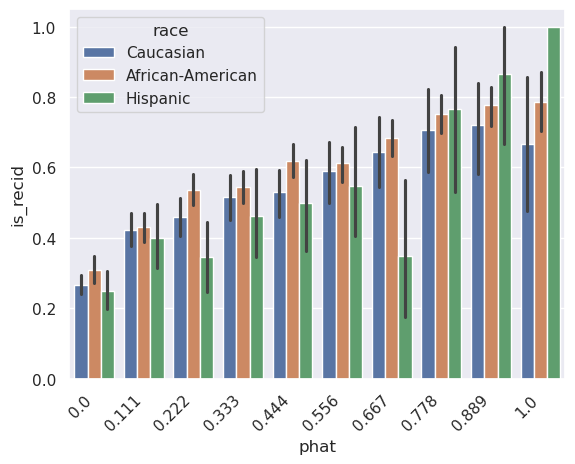

In [3]:
sns.set()
# Make a barplot with v_decile_score on the x axis and is_recid on the y axis
sns.barplot(data=df.round(3), x="phat", y="is_recid", hue="race")
# x axis tilt the labels and truncate to 2 decimal places
plt.xticks(rotation=45, ha='right')
plt.show()

In [4]:
# Run debiasing
y = torch.tensor(df.is_recid.to_numpy()).float()
yhat = torch.tensor(df.phat.to_numpy()).float()
x = torch.tensor(pd.get_dummies(df.race).values).float()

In [9]:
n = len(x)
d = x.shape[1]
model = OLSModel(torch.zeros((d,)))

# Initialize the Gradient Descent optimizer
optimizer = GD(model.parameters(), lr=0, viscosity=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
thetas = torch.zeros(n+1, d, dtype=torch.float32)
ys = torch.zeros(n+1, dtype=torch.float32)
fs = torch.zeros(n+1, dtype=torch.float32)
yhats = torch.zeros(n+1, dtype=torch.float32)
losses = torch.zeros(n+1, dtype=torch.float32)
gradients = torch.zeros(n+1, d, dtype=torch.float32)
average_losses = torch.zeros(n+1, dtype=torch.float32)
average_gradients = torch.zeros(n+1, d, dtype=torch.float32)

model = model.to(device)

loss_fn = nn.MSELoss()

for t in tqdm(range(n)):
    # Set up data
    x_t = x[t]
    y_t = y[t]
    f_t = yhat[t]
    r_t =y_t-f_t

    # Perform optimization
    optimizer.zero_grad()
    thetas[t+1] = model.theta.detach().cpu()
    prediction = model(x_t.to(device))
    r_t = r_t.to(device)
    prediction.squeeze()
    loss = loss_fn(prediction, r_t)
    loss.backward()
    optimizer.step()

    # Store results
    ys[t+1] = y_t.detach().cpu()
    fs[t+1] = f_t
    yhats[t+1] = (prediction * 2) - 1 + f_t
    losses[t+1] = loss.detach().cpu().item()
    gradients[t+1] = model.theta.grad.detach().cpu()
    average_gradients[t+1] = gradients[:t+1].mean(dim=0)
    average_losses[t+1] = losses[:t+1].mean()


100%|██████████| 6787/6787 [00:02<00:00, 3204.09it/s]


Text(0.5, 1.0, 'Average Loss over Iterations')

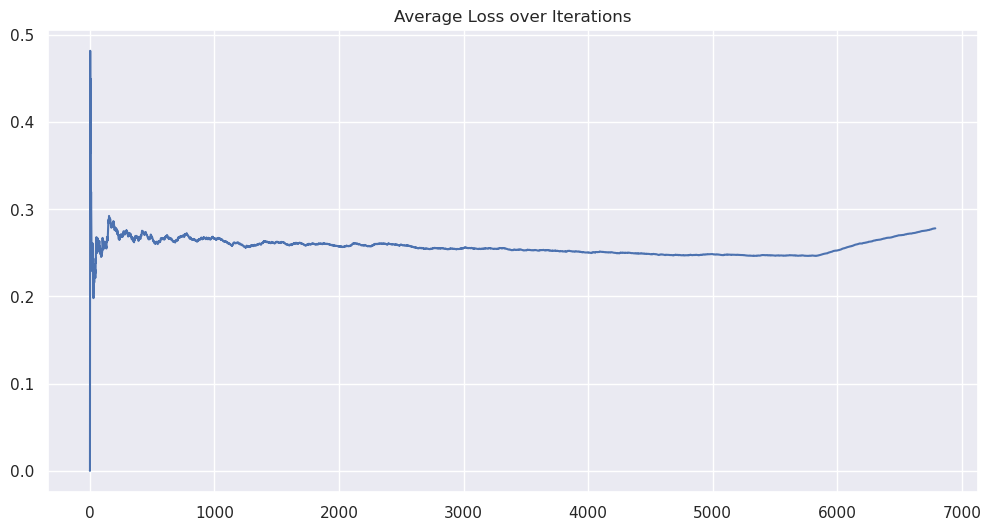

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
plt.plot(average_losses)
plt.title("Average Loss over Iterations")

Text(0.5, 1.0, 'Average Gradient over Iterations')

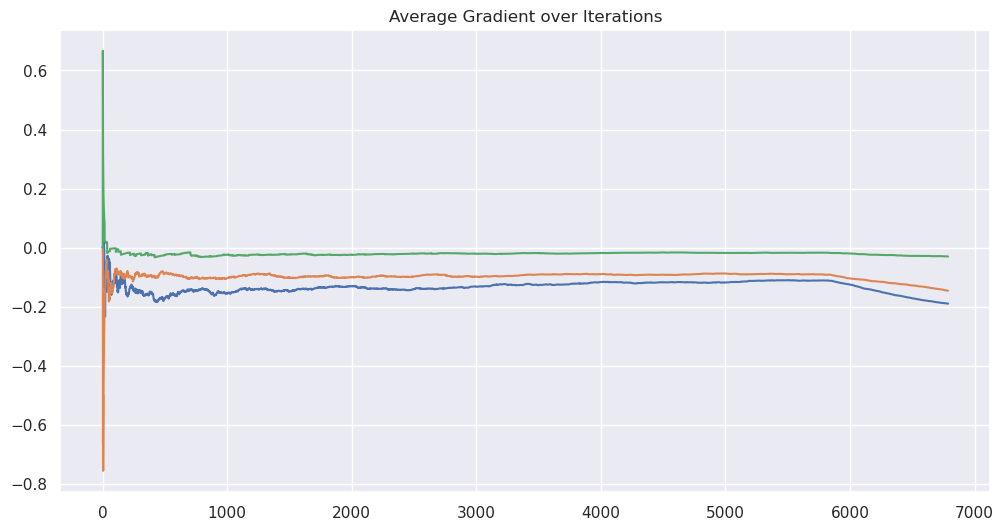

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
plt.plot(average_gradients)
plt.title("Average Gradient over Iterations")